<a href="https://colab.research.google.com/github/KarinaRmzG/Neuronal-Networks/blob/main/Neumonia_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Anális de datos exploratorio
## Caso de estudio: Neumonía en el NIH chest X-ray dataset



*An Exploratory Data Analisys (EDA) performs several statistics about the dataset in order to take better decision at the machine learning estage. Some commons statistics are to compute the patient distribution as well as the disease's correlations.*

Una de las primeras cosas o posiblemente la primer cosa que tenemos que hacer en un proceso de anális o inferencia, es conocer el conjunto de datos al que nos efrentamos, incluso aunque sea un conjunto de datos que nosotros hayamos creado existe mucha información que podemos extraer y que posiblemente no hemos tomado en cuenta.

Un análisis de datos exploratorio (EDA por sus siglás en inglés) calcula diversas estadísticas acerca del conjunto de datos a fin de tomar mejores decisiones en la etapa de anális o aprandizaje máquina. Algunas estadísticas comunes son la distribución de de la población de estudio (pacientes) asi como las etiquetas (enfermedades) y correlaciones entre ellas. En muchos casos realizar un EDA previo permitirá disminuir el tiempo de desarrollo debido a que se seleccionaran algoritmos y estrategias adecuadas. Por otro lado, un buen EDA también permite adquirir información sobre las limitaciones de los algoritmos propuestos. De forma general podemos seguir el flujo propuesto Cox.

![image.png](https://i0.wp.com/jivg.org/wp-content/uploads/2021/04/edaflow.png?ssl=1)


En este notebook se realiza un EDA del conjunto de datos NIH chest X-ray dataset con interés particular en los datos recolectados de neumonía. Debido a que en el siguiente estudio se realizá un sistema para la detección de neumonía de utilizando técnicas de aprendizaje profundo.





In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.9 MB/s eta 0:00:00


In [2]:
# Cargar paquetes necesarios
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import defaultdict
import pydicom

## fix random_state for reproducibility
random_state = 42

#Funciones Adicionales
I wrote some auxiliary fuctions to perform the EDA

A continuación se presentan varias funciones auxiliares

In [3]:
def eliminar_duplicados(lista):
    """
    Esta función toma una lista como entrada y devuelve una nueva lista
    que contiene solo los elementos únicos de la lista original en el mismo
    orden en que aparecieron, eliminando los duplicados.

    Parámetros:
    lista (list): La lista de entrada que puede contener elementos duplicados.

    Retorna:
    list: Una nueva lista que contiene elementos únicos en el mismo orden original.
    """
    res = []
    for elemento in lista:
        if elemento not in res:
            res.append(elemento)
    return res

def splitClasses(string):
    return string.split('|')

def getAllDifferentClasses(dataframe, column):
    """
    Esta función toma un dataframe y una columna como entrada y devuelve una lista
    de todas las clases únicas presentes en esa columna. Las clases están separadas
    por el carácter '|' en los valores de la columna.

    Parámetros:
    dataframe (pandas.DataFrame): El dataframe que contiene los datos etiquetados.
    column (str): El nombre de la columna en el dataframe de la que se extraerán las clases únicas.

    Retorna:
    list: Una lista de todas las clases únicas encontradas en la columna especificada.
    """
    labels = dataframe[column].unique()
    anidada = [splitClasses(cs) for cs in labels]
    labels = [l for lista in anidada for l in lista]
    return eliminar_duplicados(labels)

def getCountsDataFrame(df, column, labels):
    """
    Esta función toma un dataframe, una columna y una lista de etiquetas como entrada.
    Cuenta cuántas veces aparece cada etiqueta en la columna y devuelve un diccionario
    que mapea cada etiqueta a su conteo.

    Parámetros:
    df (pandas.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna en el dataframe en la que se contarán las etiquetas.
    labels (list): Una lista de etiquetas que se contarán en la columna.

    Retorna:
    dict: Un diccionario que mapea cada etiqueta a su conteo.
    """
    col = df[column]
    diccionario = {l: 0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        for l_individual in lsplit:
            diccionario[l_individual] += 1
    return diccionario

def getCountsColumn(col, labels):
    """
    Esta función toma una columna de etiquetas y una lista de etiquetas como entrada.
    Cuenta cuántas veces aparece cada etiqueta en la columna y devuelve un diccionario
    que mapea cada etiqueta a su conteo.

    Parámetros:
    col (list): La columna de etiquetas que se contará.
    labels (list): Una lista de etiquetas que se contarán en la columna.

    Retorna:
    dict: Un diccionario que mapea cada etiqueta a su conteo.
    """
    diccionario = {l: 0 for l in labels}
    for element in col:
        lsplit = splitClasses(element)
        for l_individual in lsplit:
            diccionario[l_individual] += 1
    return diccionario

def plotCounts(counts_dict, graphWidth, name='Counts'):
    """
    Esta función toma un diccionario de conteos, un ancho de gráfico y un nombre
    como entrada, y crea un gráfico de barras para visualizar los conteos.

    Parámetros:
    counts_dict (dict): Un diccionario que mapea etiquetas a sus conteos.
    graphWidth (int): El ancho del gráfico.
    name (str): El nombre del gráfico.

    No retorna nada, pero muestra el gráfico.
    """
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(rotation='vertical')
    plt.title(name)
    plt.bar(*zip(*counts_dict.items()), color=['red', 'green', 'blue', 'cyan', 'black'])
    plt.show()

def countPairs(df, column, la, lb):
    """
    Esta función toma un dataframe, una columna y dos etiquetas (la y lb) como entrada.
    Cuenta cuántas veces aparecen ambas etiquetas (la y lb) juntas en la columna y
    devuelve el conteo total.

    Parámetros:
    df (pandas.DataFrame): El dataframe que contiene los datos etiquetados.
    column (str): El nombre de la columna en el dataframe en la que se buscarán las etiquetas.
    la (str): La primera etiqueta a buscar.
    lb (str): La segunda etiqueta a buscar.

    Retorna:
    int: El conteo de ocurrencias de ambas etiquetas juntas en la columna.
    """
    col = df[column]
    suma = 0
    for element in col:
        lsplit = splitClasses(element)
        if la in lsplit and lb in lsplit:
            suma += 1
    return suma

def coOcurrencia(dataframe, column):
    """
    Esta función toma un dataframe y una columna como entrada. Calcula la matriz de coocurrencia
    que muestra cuántas veces aparecen dos etiquetas juntas en la misma fila de la columna y
    normaliza la matriz.

    Parámetros:
    dataframe (pandas.DataFrame): El dataframe que contiene los datos etiquetados.
    column (str): El nombre de la columna en el dataframe que se utilizará para calcular la matriz.

    Retorna:
    labels (list): Una lista de etiquetas únicas en la columna.
    matrix_coo (numpy.ndarray): Una matriz de coocurrencia normalizada que muestra las relaciones entre etiquetas.
    """
    labels = getAllDifferentClasses(dataframe, column)
    n_labels = len(labels)
    matrix_coo = np.zeros((n_labels, n_labels))

    for i, la in enumerate(labels):
        max_count = 0
        normalize = False
        for j, lb in enumerate(labels):
            count = countPairs(dataframe, column, la, lb)
            matrix_coo[i][j] = count
            if count > max_count:
                max_count = count
                normalize = True
        if normalize:
            matrix_coo[i] = matrix_coo[i] * (1 / max_count)
    return labels, matrix_coo

def plotCorrelationMatrix(labels, matrix, graphWidth, title='Correlation Matrix for'):
    """
    Esta función toma una lista de etiquetas, una matriz de coocurrencia y otros parámetros
    para visualizar una matriz de correlación.

    Parámetros:
    labels (list): Una lista de etiquetas únicas.
    matrix (numpy.ndarray): Una matriz de coocurrencia normalizada.
    graphWidth (int): El ancho del gráfico.
    title (str): El título del gráfico.

    No retorna nada, pero muestra la matriz de correlación.
    """
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(matrix, fignum=1)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(title, fontsize=15)
    plt.show()

Para importar el conjunto de datos "NIH Chest X-rays" desde Kaggle en Google Colab, sigue estos pasos:

Configura tu entorno de Kaggle en Google Colab:

Asegúrate de tener una cuenta de Kaggle.

1.   Ve a Kaggle (https://www.kaggle.com/) y crea una cuenta si no tienes una.
Luego, dirígete a la página de tu perfil de Kaggle y genera un archivo JSON de API de Kaggle. Para hacerlo, haz clic en tu foto de perfil en la esquina superior derecha, selecciona "Cuenta", desplázate hacia abajo hasta la sección "API" y haz clic en "Crear nueva API de token". Esto descargará un archivo JSON a tu computadora.
Carga el archivo JSON de API de Kaggle en Google Colab:
2.   Ve a Google Colab (https://colab.research.google.com/).
En una celda de código en Colab, ejecuta el siguiente código para cargar el archivo JSON de API de Kaggle. Asegúrate de que el archivo JSON esté en tu computadora y establece el nombre correcto del archivo en la variable kaggle_json_file. Ejecuta la celda.



In [4]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json




3.   Instala e importa la biblioteca kaggle en Colab:
En una celda de código, ejecuta los siguientes comandos para instalar la biblioteca kaggle en Colab y mover el archivo JSON de API al directorio adecuado.



In [5]:
!pip install kaggle

import os
import json

kaggle_json_file = "kaggle.json"  # Reemplaza "nombre_del_archivo.json" con el nombre de tu archivo JSON de API

# Define el directorio de configuración de Kaggle
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Copia el archivo JSON de API de Kaggle al directorio de configuración
os.rename(kaggle_json_file, os.path.join(kaggle_dir, "kaggle.json"))

# Cambia los permisos del archivo JSON
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 600)


4. Descarga el conjunto de datos "NIH Chest X-rays":
* Ejecuta el siguiente comando para descargar el conjunto de datos "NIH Chest X-rays" desde Kaggle utilizando la API de Kaggle.

In [6]:
!kaggle datasets download -d nih-chest-xrays/sample

# Verifica el contenido del directorio actual para asegurarte de que el conjunto de datos se haya descargado
!ls

100% 4.19G/4.20G [00:49<00:00, 88.9MB/s]
100% 4.20G/4.20G [00:49<00:00, 91.7MB/s]
sample_data  sample.zip


5. Descomprime el conjunto de datos:
* Ejecuta el siguiente comando para descomprimir el conjunto de datos que has descargado.

In [7]:
!unzip sample.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: sample/sample/images/00003124_000.png  
  inflating: sample/sample/images/00003129_000.png  
  inflating: sample/sample/images/00003129_001.png  
  inflating: sample/sample/images/00003129_004.png  
  inflating: sample/sample/images/00003129_009.png  
  inflating: sample/sample/images/00003129_011.png  
  inflating: sample/sample/images/00003135_000.png  
  inflating: sample/sample/images/00003140_007.png  
  inflating: sample/sample/images/00003159_001.png  
  inflating: sample/sample/images/00003169_001.png  
  inflating: sample/sample/images/00003177_002.png  
  inflating: sample/sample/images/00003186_004.png  
  inflating: sample/sample/images/00003186_005.png  
  inflating: sample/sample/images/00003190_018.png  
  inflating: sample/sample/images/00003191_001.png  
  inflating: sample/sample/images/00003198_002.png  
  inflating: sample/sample/images/00003198_005.png  
  inflating: sample/sample/image

#Datos del NIH
El conjunto de datos NIH Chest X-ray esta compuesto de 112,120 imágenes de rayos-x etiquetas provenientes de 30,805 pacientes. El objetivo de este dataset es promover el diagnóstico asistido por computadora (CAD por sus siglas en inglés) en afectaciones que sean detectables en imágenes de rayos X. Las etiquetas fueron obtenidas de forma automática mediante técnicas de procesamiento del lenguaje natural. Es importante tomar en cuanta que se espera que las etiquetas sean al menos 90 % certeras. Más detalles del conjunto de datos se pueden encontrar en las siguientes referencias:


*   Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8Hospital-ScaleChestCVPR2017_paper.pdf
*   NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community


In [8]:
from google.colab import files
uploaded = files.upload()

Saving Data_Entry_2017.csv to Data_Entry_2017.csv


In [9]:
## Load NIH data
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
nRow, nCol = all_xray_df.shape
print(f'There are {nRow} rows and {nCol} columns')

all_xray_df.sample(10)

There are 112120 rows and 12 columns


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
74982,00018387_018.png,No Finding,18,18387,57,M,AP,2500,2048,0.168000,0.168000,NaN
97972,00025849_016.png,Effusion,16,25849,58,M,AP,3056,2544,0.139000,0.139000,NaN
8273,00002191_000.png,No Finding,0,2191,47,F,PA,2048,2500,0.171000,0.171000,NaN
18316,00004877_000.png,No Finding,0,4877,53,M,PA,2048,2500,0.171000,0.171000,NaN
58599,00014502_000.png,No Finding,0,14502,59,F,PA,2810,2991,0.143000,0.143000,NaN
839,00000206_000.png,No Finding,0,206,30,M,PA,2048,2500,0.171000,0.171000,NaN
82134,00020209_006.png,Infiltration|Nodule,6,20209,67,M,PA,2992,2991,0.143000,0.143000,NaN
106955,00028871_000.png,Cardiomegaly|Effusion|Fibrosis,0,28871,43,M,PA,2020,2021,0.194311,0.194311,NaN
98562,00026057_001.png,Effusion|Fibrosis|Infiltration,1,26057,63,M,AP,3056,2544,0.139000,0.139000,NaN
26399,00006927_000.png,Mass,0,6927,51,F,AP,2500,2048,0.171000,0.171000,NaN


#Tipos de datos
El tipo de dato es importante para saber que operaciones podemos realizar sobre ellos. Revisaremos los datos que se encuentran en el CSV y las imágenes las revisaremos más tarde.

In [10]:
print('Tipos de datos: \n', all_xray_df.dtypes)

print('Tipo de datos de las etiquetas: ', type(all_xray_df['Finding Labels'][0]))

Tipos de datos: 
 Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object
Tipo de datos de las etiquetas:  <class 'str'>


OBSERVACIONES: El archivo contien variables numéricas y categóricas (cuatitativas y cualitativas). El tipo de dato de las etiquetas es cadena de texto, además todas las etiquetas se encuentran en una sola cadena separadas por el símbolo '|'.

#Crear columnas binarias
El conjunto de datos de NIH contiene ejemplos de diversas enfermedades, todas estas estan reportadas en la columna Findings Labels. Pero dado que nuestro interés está en la detección de neumonía se agregará una columna binaria para cada enfermedad, esto facilita el análisis y entrenamiento.

In [13]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases
## rather than working directly with the 'Finding Labels' column

# Extraer todas las etiquetas únicas de las 'Finding Labels'
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

# Filtrar etiquetas vacías
all_labels = [x for x in all_labels if len(x) > 0]

# Imprimir todas las etiquetas únicas
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# Crear columnas binarias para cada etiqueta de enfermedad
for c_label in all_labels:
    if len(c_label) > 1: # Dejar etiquetas vacías
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# Mostrar una muestra de 3 filas del DataFrame resultante
all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
9033,00002366_000.png,No Finding,0,2366,24,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6552,00001756_013.png,No Finding,13,1756,51,F,PA,2494,2693,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50894,00012874_008.png,No Finding,8,12874,61,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#Estudio de la población
La población sobre la que se tienen datos es de suma importancia ya que provee los alcances y limitaciones de cualquier algoritmo que se desee desarrollar sobre estos datos. A continuación se calculan las siguientes estadisticas tanto para la población completa como para la que presenta neumonía:

* Distribución de edades
* Distribución del género

##Distribución de las edades

--- Complete population ---
Average poblation age:  46.90146271851587
Younger patient: 1
Older patient 414
--- Population with Pneumonia ---
Average poblation age:  44.92732354996506
Younger patient: 2
Older patient 412


<ipython-input-14-80a186e845f4>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


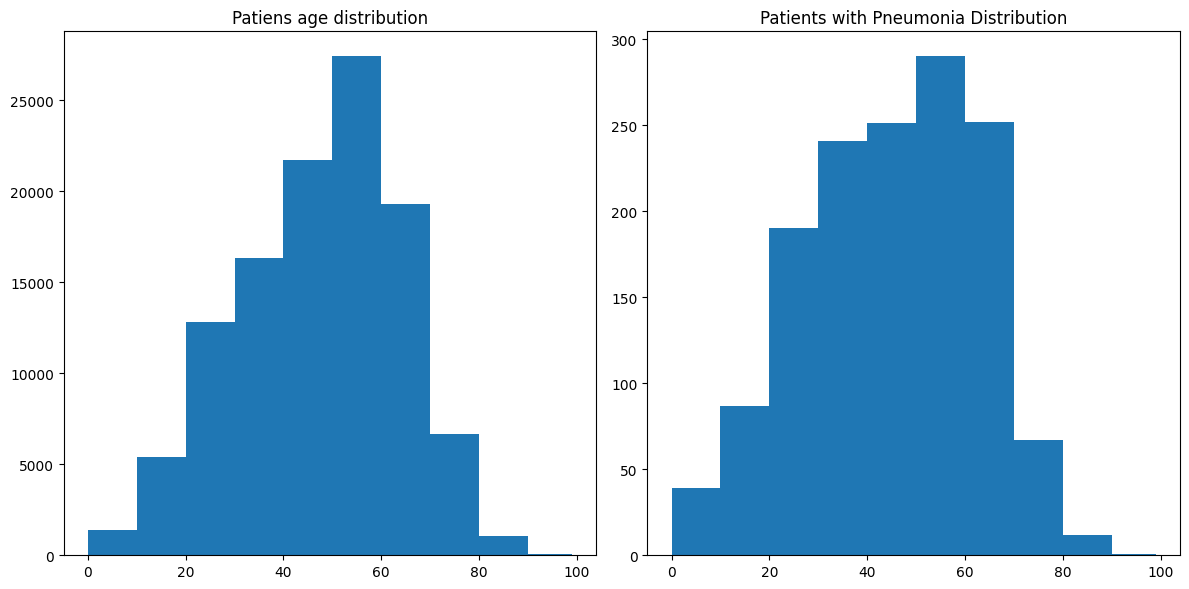

In [14]:
# Get average Age
ages = all_xray_df['Patient Age']

# Calcular la edad promedio de la población
average_age = np.average(ages)
print("--- Complete population ---")
print("Average poblation age: ", average_age)
print("Younger patient:", np.min(ages))
print("Older patient", np.amax(ages))

# Crear una figura para los gráficos
fig = plt.subplots(figsize=(12, 6))

# Gráfico 1: Distribución de edades de la población completa
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=1.0)
ax = plt.hist(ages, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])
plt.title('Patiens age distribution')
plt.tight_layout()

# Identificar pacientes con neumonía y calcular sus edades
with_pneumonia = np.array(all_xray_df['Pneumonia'])
indexes = np.where(with_pneumonia == 1)[0]
ages_pneu = ages[list(indexes)]

# Calcular la edad promedio de pacientes con neumonía
print("--- Population with Pneumonia ---")
print("Average poblation age: ", np.average(ages_pneu))
print("Younger patient:", np.min(ages_pneu))
print("Older patient", np.amax(ages_pneu))

# Gráfico 2: Distribución de edades de pacientes con neumonía
plt.subplot(1, 2, 2)
plt.subplots_adjust(hspace=1.0)
ax = plt.hist(ages_pneu, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])
plt.title('Patients with Pneumonia Distribution')
plt.tight_layout()

OBSERVATION: We can observe that the patients age with pneumonia distribution follows a similar distribution with respect to the whole study population. I detected an outlier in the maximum age, it is maybe a labeling error.

OBSERVACION: La distribución de las edades de los pacientes clasificados con neumonía es similar a la distribución de la población completa. Además, las edades leídas tienen unos outliers, dado que está registrada una edad de 414 años en la población de estudio.

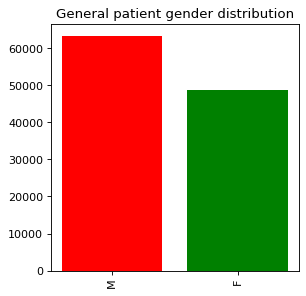

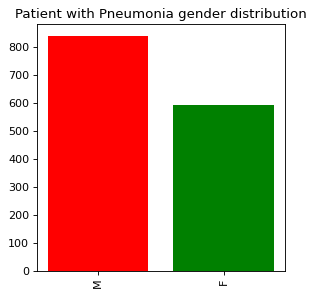

In [15]:
# Plot gender distribution
column = 'Patient Gender'

# Obtener las etiquetas únicas de género
labels = getAllDifferentClasses(all_xray_df, column)

# Calcular el conteo de género en la población general
dict_counts = getCountsDataFrame(all_xray_df, column, labels)

# Mostrar un gráfico de barras para la distribución de género en la población general
plotCounts(dict_counts, 4, name="General patient gender distribution")

# Identificar género de pacientes con neumonía y calcular sus conteos
gender_with_pneu = np.array(all_xray_df[column])[list(indexes)]
dict_counts = getCountsColumn(gender_with_pneu, labels)

# Mostrar un gráfico de barras para la distribución de género en pacientes con neumonía
plotCounts(dict_counts, 4, name="Patient with Pneumonia gender distribution")


OBSERVATION: In both cases, for the whole dataset and for patiends with pneumonia, the number of male examples is higher than female examples.

OBSERVACION: Tanto para la población completa como la que tiene neumonía, el numeró de ejemplos para masculinos es mayor que la de femeninos.

#Distribución de las enfermedades halladas
Se muestra la distribución de las enfermedades detectadas.

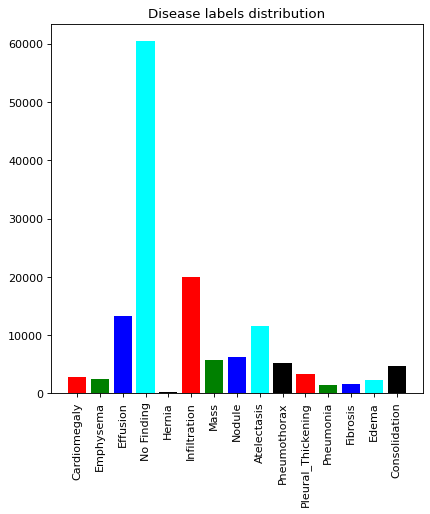

Neumonia Cases: 1431
No neumonia Cases: 110689


In [16]:
# Plot disease labels distribution
column = 'Finding Labels'

# Obtener las etiquetas únicas de enfermedades
labels = getAllDifferentClasses(all_xray_df, column)

# Calcular el conteo de etiquetas de enfermedades en la población
dict_counts = getCountsDataFrame(all_xray_df, column, labels)

# Mostrar un gráfico de barras que representa la distribución de etiquetas de enfermedades
plotCounts(dict_counts, 6, name='Disease labels distribution')

# Imprimir el número de casos de neumonía y no neumonía
print('Neumonia Cases:', dict_counts['Pneumonia'])
print('No neumonia Cases:', nRow - dict_counts['Pneumonia'])

OBSERVATION: The number of pneumonia cases is much less than the number of total examples. The largest number is for cases with no findings

OBSERVACION: La cantidad de ejemplos de neumonia es mucho menos que los ejemplos del conjunto de datos. El mayor numero de casos reportados es de aquellos que no tienen hallazgos

#Distribución de las posiciones de vista
Se muestra la distribución de las posiciones desde donde se tomaron los rayos x (posicion de vista).

['PA', 'AP']


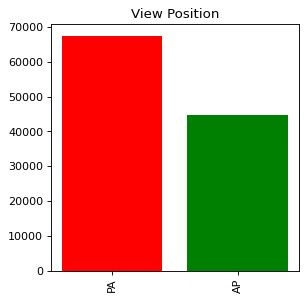

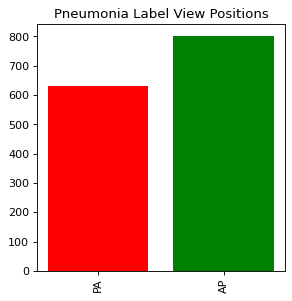

Anteroposterior images: 801


In [17]:
column = 'View Position'

# Obtener las etiquetas únicas de posiciones de vista
labels = getAllDifferentClasses(all_xray_df, column)

# Imprimir las etiquetas únicas de posiciones de vista
print(labels)

# Calcular el conteo de cada etiqueta de posición de vista en la población
dict_counts = getCountsDataFrame(all_xray_df, column, labels)

# Mostrar un gráfico de barras que representa la distribución de posiciones de vista
plotCounts(dict_counts, 4, name='View Position')

# Identificar posiciones de vista en pacientes con neumonía y calcular sus conteos
views_with_pneu = np.array(all_xray_df[column])[list(indexes)]
dict_counts = getCountsColumn(views_with_pneu, labels)

# Mostrar un gráfico de barras que representa la distribución de posiciones de vista en pacientes con neumonía
plotCounts(dict_counts, 4, name="Pneumonia Label View Positions")

# Imprimir el número de imágenes con posición "Anteroposterior"
print("Anteroposterior images:", dict_counts['AP'])

OBSERVATION: The number of AP images for pneumonia cases is higher than the number of AP. Contrary to the whole population where PA is higher than AP.

* AP, anteroposterior: Proyección en la que el paciente está situado de frente a la parte generadora o a la fuente de energía, en el momento de la adquisición de una imagen.
* PA, Posteroanterior: Proyección en la que el paciente está situado de espalda a la parte generadora o fuente de energía.

# Número de enfermedades detectadas

defaultdict(<function <lambda> at 0x784698ed6950>, {1: 30963, 2: 14306, 4: 1247, 3: 4856, 5: 301, 6: 67, 7: 16, 8: 1, 9: 2})


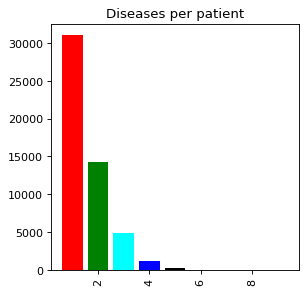

In [18]:
# Obtener la columna de etiquetas de enfermedades
labelsmix = all_xray_df['Finding Labels']

# Calcular la cantidad de etiquetas de enfermedades por fila (por paciente)
diseases_per_row = [len(element) for element in labelsmix]

# Inicializar un diccionario para contar pacientes con enfermedades
diseases_per_patient = defaultdict(lambda: 0)

# Etiqueta para pacientes sin enfermedades
no_disease = 'No Finding'

# Iterar a través de las etiquetas de enfermedades en las filas
for diseases in labelsmix:
    lbls = splitClasses(diseases)
    if no_disease not in lbls:
        diseases_per_patient[len(lbls)] += 1

# Imprimir el conteo de pacientes con diferentes cantidades de enfermedades
print(diseases_per_patient)

# Mostrar un gráfico de barras que representa la cantidad de enfermedades por paciente
plotCounts(diseases_per_patient, 4, name='Diseases per patient')

# Comorbilities

In [22]:
# Comorbid
column = 'Finding Labels'

# Obtener las etiquetas únicas de enfermedades
labels = getAllDifferentClasses(all_xray_df, column)

# Filtrar las filas del DataFrame donde 'Pneumonia' es igual a 1 y sumar las etiquetas de enfermedades
all_xray_df[all_xray_df.Pneumonia==1][labels].sum()

Cardiomegaly            41.0
Emphysema               23.0
Effusion               269.0
No Finding               0.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
Nodule                  70.0
Atelectasis            262.0
Pneumothorax            41.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Fibrosis                11.0
Edema                  340.0
Consolidation          123.0
dtype: float64

<Axes: >

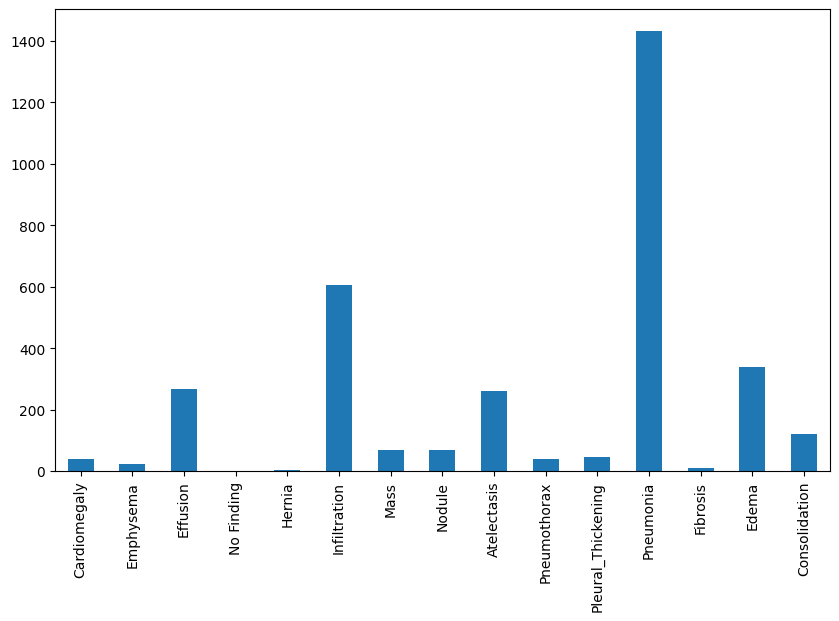

In [23]:
# Crear una figura con un tamaño específico
plt.figure(figsize=(10,6))
# Generar un gráfico de barras a partir de los conteos de enfermedades en pacientes con neumonía
all_xray_df[all_xray_df.Pneumonia==1][labels].sum().plot(kind='bar')

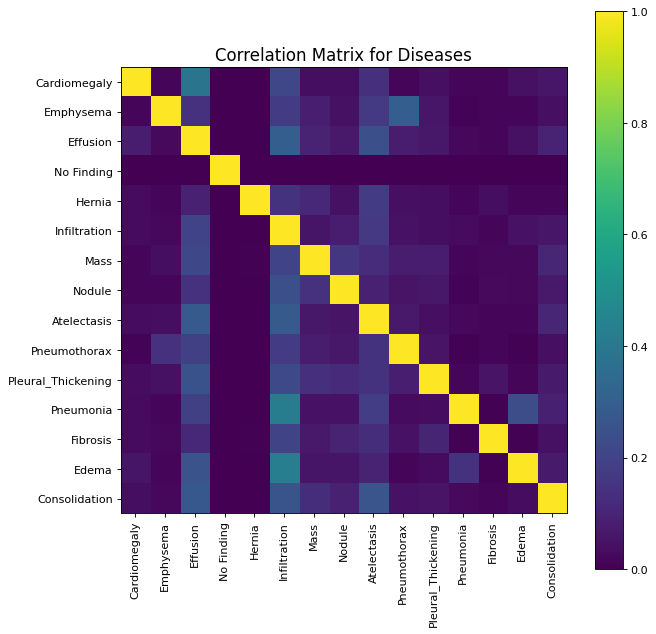

In [24]:
# Define la columna 'Finding Labels' que contiene información sobre las etiquetas de enfermedades en los pacientes.
column = 'Finding Labels'

# Calcula la matriz de coocurrencia de enfermedades y obtiene las etiquetas de enfermedades únicas.
labels, matco = coOcurrencia(all_xray_df, column)

# Muestra una matriz de correlación de enfermedades en forma de gráfico.
plotCorrelationMatrix(labels, matco, 9, title='Correlation Matrix for Diseases')

OBSERVATIONS: From the previous correlation matrix we can observe that pneumonia is highly correlated with Infiltration. In second place it is correlated with Effusion and Edema.

OBSERVACIONES: A partir de la matriz de correlación podemos observar que Neumonía esta altamente correlacionada con Infiltración, en segundo lugar está correlacionada con Effusion y con Edema.

# Imágenes de Ejemplo
Leeremos un conjunto reducido de imágenes para poder analizarlas

In [25]:
# Cargar los datos desde el archivo 'sample_labels.csv' para evaluaciones a nivel de píxeles
sample_df = pd.read_csv('sample_labels.csv')

# Imprimir la longitud del DataFrame 'sample_df' (cantidad de filas)
print('Sample data length:', len(sample_df))

# Muestra una muestra aleatoria de 10 filas del DataFrame 'sample_df'
sample_df.sample(10)

Sample data length: 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4978,00026235_000.png,Effusion|Mass,0,26235,062Y,F,PA,2742,2991,0.143,0.143
1927,00010032_010.png,Mass,10,10032,066Y,F,AP,2500,2048,0.168,0.168
41,00000243_001.png,Emphysema,1,243,069Y,M,PA,2500,2048,0.168,0.168
3896,00019190_000.png,Infiltration,0,19190,057Y,M,PA,2992,2991,0.143,0.143
4196,00020624_011.png,No Finding,11,20624,070Y,M,PA,2838,2991,0.143,0.143
1959,00010270_006.png,Pneumothorax,6,10270,017Y,M,AP,2500,2048,0.168,0.168
4807,00025260_000.png,No Finding,0,25260,037Y,F,PA,3056,2544,0.139,0.139
4523,00022574_000.png,Effusion|Infiltration,0,22574,046Y,M,PA,2992,2991,0.143,0.143
25,00000127_007.png,Effusion,7,127,056Y,F,AP,2500,2048,0.168,0.168
1734,00009138_022.png,No Finding,22,9138,068Y,M,PA,2500,2048,0.168,0.168


# Pixel level information

In [26]:
# Again we will see the data
print(os.listdir('./'))

['.config', 'sample', 'sample_labels.csv', 'sample.zip', 'Data_Entry_2017.csv', 'sample_data']


In [27]:
# Read the DICOM's pixel_array attribute into a dataframe using the pydicom.dcmread function
dcm = pydicom.dcmread('test1.dcm')

FileNotFoundError: ignored

In [28]:
print('Tipo de dato de las imágenes:', type(dcm.pixel_array[0][0]))
# visualize the image
plt.imshow(dcm.pixel_array,cmap='gray')

NameError: ignored

In [29]:
# Agregar una columna que sea el path
sample_df_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/data', 'images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(sample_df_paths.get)
sample_df.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143,None
1879,00009892_001.png,No Finding,1,9892,062Y,F,PA,2992,2991,0.143,0.143,None
346,00001836_076.png,Mass|Nodule,76,1836,050Y,F,AP,2500,2048,0.168,0.168,None


In [30]:
sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for name in sample_labels:
    sample_df[name] = sample_df['Finding Labels'].map(lambda finding: 1.0 if name in finding else 0)
    print('%s: %d'%(name, int(sample_df[name].sum())))

Atelectasis: 508
Cardiomegaly: 141
Consolidation: 226
Edema: 118
Effusion: 644
Emphysema: 127
Fibrosis: 84
Hernia: 13
Infiltration: 967
Mass: 284
No Finding: 3044
Nodule: 313
Pleural_Thickening: 176
Pneumonia: 62
Pneumothorax: 271


AttributeError: ignored

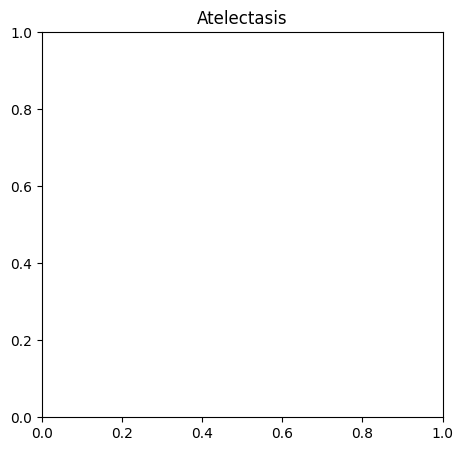

In [32]:
for name in sample_labels:
    img_path = sample_df[sample_df["Finding Labels"] == name].sample(5, random_state=random_state)["path"]
    plt.figure(figsize = (30, 5))
    for i in range(len(img_path)):
        plt.subplot(1, len(img_path), i + 1).set_title(name)
        var = plt.imread(img_path.iloc[i])
        plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

OBSERVATIONS: Histograms do not show a clear pattern for the same disease. Therefore, histograms are not enough for classification. More features should be taken into account. For example spatial features. In addition, some peaks for certain pixel values are found, those peaks seem to occur in random values, this support the need of computing more features.

OBSERVACIONES: Los histogramas no muestran patrones claros entre enfermdades. Adicionalmente, algunos picos en la frecuencia aparecen de forma aleatoria. Por lo cual es necesario calcular más características en las imágenes, por ejemplo, características espaciales.

##Conclusions
Some of the conclusions we can found after performing the EDA are:

* The age distribution is similar to a normal distribution, where the mean is close to 50 years hold. This implies that the algoritms that use this data probably will work better for patiend with an age close to the mean age.
* The data is almost balanced in terms of patient genre. Therefore, the training and metrics shoud work properly for both genres.
* The amount of pneumonia examples is much less with respect to the whole dataset. They are only 1431.
* Classes as imbalanced in terms of findings, the majoritary class of 'no findings' can be more than ten times the number of examples from the pneumonia class. Therefore, we have to some techniques for adrressing the umbalanced problem, for example, at training stage, a balanced sub-dataset can be made using subsampling.
* The correlation matrix shows that pneumonia is correlated with infiltration, this information could be used to improve the detection of pneumonia if infiltration is present.
* With respect to pixel information, histograms can vary between images, a histogram equalization can be made, - however, this preprocessing must be validated by the accuracy reached.
##References
* Cox V. (2017) Exploratory Data Analysis. In: Translating Statistics to Make Decisions. Apress, Berkeley, CA. https://doi.org/10.1007/978-1-4842-2256-0_3